<img src="https://i.imgur.com/fOeJmu3.jpg" width="600px">

# Introduction

Hello everyone! In this project, I will try to finetune roBERTa base to predict the sentiment of a tweet. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds. Building machine learning models to understand the sentiment behind a tweet can help drive decisions by many parties and leverage the large amount of information on Twitter. 

I will use **PyTorch XLA** (PyTorch for TPUs) and **huggingface transformers** for this project.

## Set up PyTorch-XLA

* These few lines of code sets up PyTorch XLA for us.
* We need PyTorch XLA to help us train PyTorch models on TPU.

In [1]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev
!export XLA_USE_BF16=1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  99162      0 --:--:-- --:--:-- --:--:-- 99162
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-nightly ...
Found existing installation: torch 1.5.0
Uninstalling torch-1.5.0:
Done updating TPU runtime: <Response [200]>
  Successfully uninstalled torch-1.5.0
Found existing installation: torchvision 0.6.0a0+82fd1c8
Uninstalling torchvision-0.6.0a0+82fd1c8:
  Successfully uninstalled torchvision-0.6.0a0+82fd1c8
Copying gs://tpu-pytorch/wheels/torch-nightly-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/91.1 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly-cp37-cp37m-linux_x86_64.whl...

Operation completed over 1 objects/120.3 MiB.                                    
Copying gs://tpu-pytorch/wheels/torchv

## Install and import libraries

* We will import several different packages and libraries required for different parts of the project. For example, we import numpy and pandas for data manipulation, torch and torch_xla for modeling, and matplotlib for visualization.

In [2]:
!pip install -q colored
!pip install -q transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import os
import gc
import re

import time
import colored
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from colored import fg, bg, attr

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.multiprocessing import Pipe, Process
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler

from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from transformers import RobertaModel, RobertaTokenizer

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences as pad

Using TensorFlow backend.


## Define hyperparameters and load data

* Here, we define the required hyperparameters such as the training batch size, learning rate, training/validation split percentage, etc.
* We also load the training and tessting data required for the project using the read_csv function from the pandas library.

In [4]:
EPOCHS = 20
SPLIT = 0.8
MAXLEN = 48
DROP_RATE = 0.3
np.random.seed(42)

OUTPUT_UNITS = 3
BATCH_SIZE = 384
LR = (4e-5, 1e-2)
ROBERTA_UNITS = 768
VAL_BATCH_SIZE = 384
MODEL_SAVE_PATH = 'sentiment_model.pt'

In [5]:
test_df = pd.read_csv('../input/tweet-sentiment-extraction/test.csv')
train_df = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')

In [6]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [7]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


## Define PyTorch Dataset

* Now we define a PyTorch Dataset which will help us feed data to the roBERTa model for training and inference.
* We remove leading and trailing whitespaces using .strip(), tokenize the values using huggingface, and pad the tokens using keras.

In [8]:
class TweetDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.text = data.text
        self.tokenizer = tokenizer
        self.sentiment = data.sentiment
        self.sentiment_dict = {"positive": 0, "neutral": 1, "negative": 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        start, finish = 0, 2
        pg, tg = 'post', 'post'
        tweet = str(self.text[i]).strip()
        tweet_ids = self.tokenizer.encode(tweet)

        attention_mask_idx = len(tweet_ids) - 1
        if start not in tweet_ids: tweet_ids = start + tweet_ids
        tweet_ids = pad([tweet_ids], maxlen=MAXLEN, value=1, padding=pg, truncating=tg)

        attention_mask = np.zeros(MAXLEN)
        attention_mask[1:attention_mask_idx] = 1
        attention_mask = attention_mask.reshape((1, -1))
        if finish not in tweet_ids: tweet_ids[-1], attention_mask[-1] = finish, start
            
        sentiment = [self.sentiment_dict[self.sentiment[i]]]
        sentiment = torch.FloatTensor(to_categorical(sentiment, num_classes=3))
        return sentiment, torch.LongTensor(tweet_ids), torch.LongTensor(attention_mask)

## Define roBERTa-base model

* Now, we get to the interesting part: training roBERTa base! roBERTa base is a pretrained language model developed by Facebook AI.
* We will use roBERTa with its pretrained weights and add a custom (Dropout + Dense) head at the top to turn it into a binary text classifier.

In [9]:
class Roberta(nn.Module):
    def __init__(self):
        super(Roberta, self).__init__()
        self.softmax = nn.Softmax(dim=1)
        self.drop = nn.Dropout(DROP_RATE)
        self.roberta = RobertaModel.from_pretrained(model)
        self.dense = nn.Linear(ROBERTA_UNITS, OUTPUT_UNITS)
        
    def forward(self, inp, att):
        inp = inp.view(-1, MAXLEN)
        _, self.feat = self.roberta(inp, att)
        return self.softmax(self.dense(self.drop(self.feat)))

## Define tokenizer

* Here we simply define the RobertaTokenizer from huggingface which we use in the Dataset to generate tokens from words.

In [10]:
model = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model)

## Define cross entropy and accuracy

* Here we implement categorical cross entropy and accuracy functions in PyTorch.
* CEL is the loss function which is commonly used in classification tasks and helps us finetune roBERTa's weights.

In [11]:
def cel(inp, target):
    _, labels = target.max(dim=1)
    return nn.CrossEntropyLoss()(inp, labels)*len(inp)

def accuracy(inp, target):
    inp_ind = inp.max(axis=1).indices
    target_ind = target.max(axis=1).indices
    return (inp_ind == target_ind).float().sum(axis=0)

## Train model on all 8 TPU cores

* Now, we will train the roBERTa base model to classify tweet sentiments.
* We define a simple training loop in PyTorch to train the model and validate it after each epoch.
* We parallelize the training on all 8 TPU cores using <code>xmp.spawn</code> from PyTorch XLA (distributes training).
* We aslo use <code>DistributedSampler</code> and <code>ParallelLoader</code> to parallelize data sampling and model training.

In [12]:
m = Roberta(); print(m)


Roberta(
  (softmax): Softmax(dim=1)
  (drop): Dropout(p=0.3, inplace=False)
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bia

In [13]:
del m; gc.collect()

595

In [14]:
def print_metric(data, batch, epoch, start, end, metric, typ):
    t = typ, metric, "%s", data, "%s"
    if typ == "Train": pre = "BATCH %s" + str(batch-1) + "%s  "
    if typ == "Val": pre = "\nEPOCH %s" + str(epoch+1) + "%s  "
    time = np.round(end - start, 1); time = "Time: %s{}%s s".format(time)
    fonts = [(fg(211), attr('reset')), (fg(212), attr('reset')), (fg(213), attr('reset'))]
    xm.master_print(pre % fonts[0] + "{} {}: {}{}{}".format(*t) % fonts[1] + "  " + time % fonts[2])

In [15]:
global val_losses; global train_losses
global val_accuracies; global train_accuracies

def train_fn():
    size = 1
    torch.manual_seed(42)
    train_df = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')

    train_df = shuffle(train_df)
    split = np.int32(SPLIT*len(train_df))
    val_df, train_df = train_df[split:], train_df[:split]

    val_df = val_df.reset_index(drop=True)
    val_set = TweetDataset(val_df, tokenizer)
    val_sampler = DistributedSampler(val_set, num_replicas=8,
                                     rank=xm.get_ordinal(), shuffle=True)

    train_df = train_df.reset_index(drop=True)
    train_set = TweetDataset(train_df, tokenizer)
    train_sampler = DistributedSampler(train_set, num_replicas=8,
                                       rank=xm.get_ordinal(), shuffle=True)
    
    val_loader = DataLoader(val_set, VAL_BATCH_SIZE,
                            sampler=val_sampler, num_workers=0, drop_last=True)

    train_loader = DataLoader(train_set, BATCH_SIZE,
                              sampler=train_sampler, num_workers=0, drop_last=True)

    device = xm.xla_device()
    network = Roberta().to(device)
    optimizer = Adam([{'params': network.dense.parameters(), 'lr': LR[1]*size},
                      {'params': network.roberta.parameters(), 'lr': LR[0]*size}])

    val_losses, val_accuracies = [], []
    train_losses, train_accuracies = [], []
    
    start = time.time()
    xm.master_print("STARTING TRAINING ...\n")

    for epoch in range(EPOCHS):

        batch = 1
        network.train()
        fonts = (fg(48), attr('reset'))
        xm.master_print(("EPOCH %s" + str(epoch+1) + "%s") % fonts)

        val_parallel = pl.ParallelLoader(val_loader, [device]).per_device_loader(device)
        train_parallel = pl.ParallelLoader(train_loader, [device]).per_device_loader(device)
        
        for train_batch in train_parallel:
            train_targ, train_in, train_att = train_batch
            
            network = network.to(device)
            train_in = train_in.to(device)
            train_att = train_att.to(device)
            train_targ = train_targ.to(device)

            train_preds = network.forward(train_in, train_att)
            train_loss = cel(train_preds, train_targ.squeeze(dim=1))/len(train_in)
            train_accuracy = accuracy(train_preds, train_targ.squeeze(dim=1))/len(train_in)

            optimizer.zero_grad()
            train_loss.backward()
            xm.optimizer_step(optimizer)
            
            end = time.time()
            batch = batch + 1
            acc = np.round(train_accuracy.item(), 3)
            print_metric(acc, batch, None, start, end, metric="acc", typ="Train")

        val_loss, val_accuracy, val_points = 0, 0, 0

        network.eval()
        with torch.no_grad():
            for val_batch in val_parallel:
                targ, val_in, val_att = val_batch

                targ = targ.to(device)
                val_in = val_in.to(device)
                val_att = val_att.to(device)
                network = network.to(device)
            
                val_points += len(targ)
                pred = network.forward(val_in, val_att)
                val_loss += cel(pred, targ.squeeze(dim=1)).item()
                val_accuracy += accuracy(pred, targ.squeeze(dim=1)).item()
        
        end = time.time()
        val_loss /= val_points
        val_accuracy /= val_points
        acc = xm.mesh_reduce('acc', val_accuracy, lambda x: sum(x)/len(x))
        print_metric(np.round(acc, 3), None, epoch, start, end, metric="acc", typ="Val")
    
        xm.master_print("")
        val_losses.append(val_loss); train_losses.append(train_loss.item())
        val_accuracies.append(val_accuracy); train_accuracies.append(train_accuracy.item())

    xm.master_print("ENDING TRAINING ...")
    xm.save(network.state_dict(), MODEL_SAVE_PATH); del network; gc.collect()

    metric_names = ['val_loss_', 'train_loss_', 'val_acc_', 'train_acc_']
    metric_lists = [val_losses, train_losses, val_accuracies, train_accuracies]
    
    for i, metric_list in enumerate(metric_lists):
        for j, metric_value in enumerate(metric_list):
            torch.save(metric_value, metric_names[i] + str(j) + '.pt')

In [16]:
def _mp_fn(rank, flags):
    train_fn()

FLAGS = {}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')

STARTING TRAINING ...

EPOCH 1
BATCH 1  Train acc: 0.346  Time: 4.9 s
BATCH 2  Train acc: 0.391  Time: 76.2 s
BATCH 3  Train acc: 0.43  Time: 133.9 s
BATCH 4  Train acc: 0.383  Time: 134.9 s
BATCH 5  Train acc: 0.37  Time: 136.0 s
BATCH 6  Train acc: 0.453  Time: 137.1 s
BATCH 7  Train acc: 0.464  Time: 138.2 s

EPOCH 1  Val acc: 0.393  Time: 162.5 s

EPOCH 2
BATCH 1  Train acc: 0.451  Time: 166.2 s
BATCH 2  Train acc: 0.391  Time: 167.6 s
BATCH 3  Train acc: 0.448  Time: 168.7 s
BATCH 4  Train acc: 0.469  Time: 169.7 s
BATCH 5  Train acc: 0.453  Time: 170.8 s
BATCH 6  Train acc: 0.526  Time: 171.9 s
BATCH 7  Train acc: 0.542  Time: 172.9 s

EPOCH 2  Val acc: 0.553  Time: 174.2 s

EPOCH 3
BATCH 1  Train acc: 0.523  Time: 177.6 s
BATCH 2  Train acc: 0.549  Time: 178.8 s
BATCH 3  Train acc: 0.617  Time: 180.0 s
BATCH 4  Train acc: 0.583  Time: 181.1 s
BATCH 5  Train acc: 0.599  Time: 182.1 s
BATCH 6  Train acc: 0.706  Time: 183.2 s
BATCH 7  Train acc: 0.654  Time: 184.2 s

EPOCH 3  Val a

## Visualize loss and accuracy over time

* We now visualize how the loss and accuracy of the model change over time.
* We can see that the model eventually converges to around 80% accuracy towards the end.

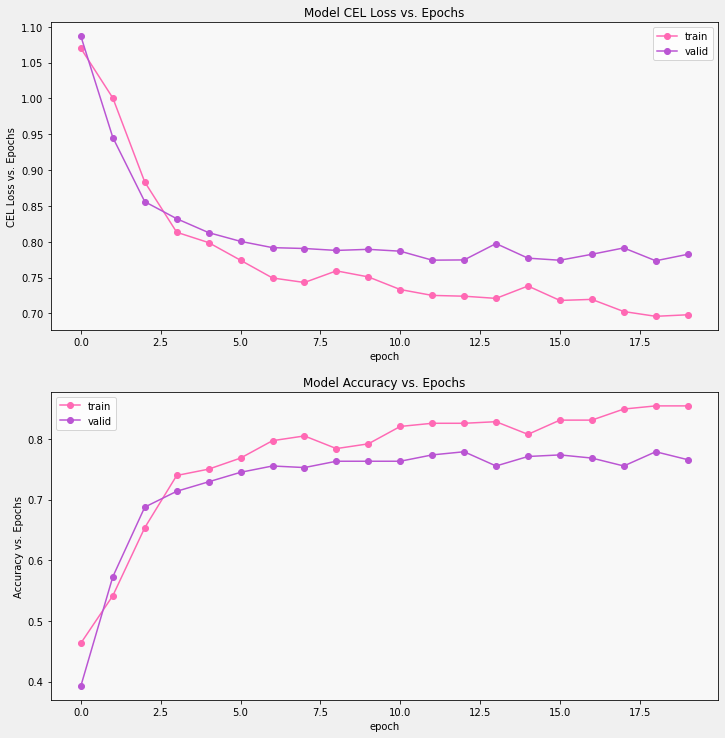

In [17]:
def display_training_curves(training, validation, title, subplot):

    if subplot%10==1:
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()

    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training, color="hotpink", marker='o')
    ax.plot(validation, color="mediumorchid", marker='o')
    

    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.set_title('Model '+ title)
    ax.legend(['train', 'valid'])

val_losses = [torch.load('val_loss_{}.pt'.format(i)) for i in range(EPOCHS)]
train_losses = [torch.load('train_loss_{}.pt'.format(i)) for i in range(EPOCHS)]
val_accuracies = [torch.load('val_acc_{}.pt'.format(i)) for i in range(EPOCHS)]
train_accuracies = [torch.load('train_acc_{}.pt'.format(i)) for i in range(EPOCHS)]

display_training_curves(train_losses, val_losses, "CEL Loss vs. Epochs", 211)
display_training_curves(train_accuracies, val_accuracies, "Accuracy vs. Epochs", 212)

## Load model

* We now load the model to evaluate its performance.

In [18]:
network = Roberta()
network.load_state_dict(torch.load('sentiment_model.pt'))

<All keys matched successfully>

## Sample sentiment prediction

* We will now see how the model performs on sample comments.
* It appears to classify sentiment pretty accurately in these simple examples.

In [19]:
device = xm.xla_device()
network = network.to(device)

def predict_sentiment(tweet):
    pg, tg = 'post', 'post'
    tweet_ids = tokenizer.encode(tweet.strip())
    sent = {0: 'positive', 1: 'neutral', 2: 'negative'}

    att_mask_idx = len(tweet_ids) - 1
    if 0 not in tweet_ids: tweet_ids = 0 + tweet_ids
    tweet_ids = pad([tweet_ids], maxlen=MAXLEN, value=1, padding=pg, truncating=tg)

    att_mask = np.zeros(MAXLEN)
    att_mask[1:att_mask_idx] = 1
    att_mask = att_mask.reshape((1, -1))
    if 2 not in tweet_ids: tweet_ids[-1], att_mask[-1] = 2, 0
    tweet_ids, att_mask = torch.LongTensor(tweet_ids), torch.LongTensor(att_mask)
    return sent[np.argmax(network.forward(tweet_ids.to(device), att_mask.to(device)).detach().cpu().numpy())]

In [20]:
predict_sentiment("It does not look good now ...")

'negative'

In [21]:
predict_sentiment("I want to know more about your product.")

'neutral'

In [22]:
predict_sentiment("I have done something good today and so should you :D")

'positive'